Significancia:

$$Z = \frac{S}{\sqrt{S+B}}$$

In [1]:
import awkward as ak
import pandas as pd
import numpy as np
import vector
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema, DelphesSchema
import mplhep as hep
import matplotlib.pyplot as plt
import seaborn as sns
import DM_HEP_AN as dm
from math import pi
from funcs import *
hep.style.use("CMS")
#%matplotlib inline
plt.ioff()

In [2]:
# Signal
cases = ["gSq_only","gSg1_only", "gSg2_only_y0y0", "gSg_only"]
data = {}
for i in cases:
    csvFile = [f"./sim_outputs/csv/DM_{i}_1.csv", f"./sim_outputs/csv/DM_{i}_2.csv"]
    data[i] = [pd.read_csv(j) for j in csvFile]

In [3]:
print("Número de Eventos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])

Número de Eventos:  [[50000, 50000], [50000, 50000], [50000, 50000], [50000, 50000]]


In [4]:
# Background
csvFile = "./background/ZpJets.csv"
data_ZpJ = pd.read_csv(csvFile)
csvFile = "./background/WpJets.csv"
data_WpJ = pd.read_csv(csvFile)

Cross-section

In [5]:
CSs = {}
for i in cases:
    CSs[f"{i}"] = []
    CSs[f"error{i}"] = []

In [6]:
outFile = "sim_outputs/log.out"
outData = open(outFile, "r")
outText = outData.read()
outData.close()

In [7]:
indexCS = outText.find('Cross-section :   ')
indexPM = outText.find(' +- ', indexCS)
indexPB = outText.find(' pb', indexCS)
counter = 0
repCount = True
run = 1
while indexCS != -1:
    if repCount:
        repCount = False
    else:
        #print("Cross-section: ", outText[indexCS+18:indexPM])
        #print("errorbar :", outText[indexPM+4:indexPB])
        CSs[f"{cases[counter]}"].append(float(outText[indexCS+18:indexPM]))
        CSs[f"error{cases[counter]}"].append(float(outText[indexPM+4:indexPB]))
        match run:
            case 1:
                run = 2
            case 2:
                run = 1
                counter +=1
        repCount = True
    indexCS = outText.find('Cross-section :   ', indexCS+1)
    indexPM = outText.find(' +- ', indexCS)
    indexPB = outText.find(' pb', indexCS)
print(counter)

4


In [8]:
CSs

{'gSq_only': [0.0008833, 3.692e-05],
 'errorgSq_only': [1.722e-06, 7.012e-08],
 'gSg1_only': [41.16, 6.965],
 'errorgSg1_only': [0.06192, 0.01127],
 'gSg2_only_y0y0': [0.002104, 0.0001629],
 'errorgSg2_only_y0y0': [3.224e-06, 2.454e-07],
 'gSg_only': [41.2, 6.972],
 'errorgSg_only': [0.06122, 0.01005]}

In [9]:
# fictious cross section
newCS = 0.1 # pb (100 fb)
CSs['gSq_only'] = [newCS, newCS]
CSs['gSg2_only_y0y0'] = [newCS, newCS]

In [10]:
for i in cases:
    for j in range(2):
        data[i][j]["pseudorapidityProd"] = data[i][j].apply(pseudorapidity_product, axis=1)

data_WpJ["pseudorapidityProd"] = data_WpJ.apply(pseudorapidity_product, axis=1)
data_ZpJ["pseudorapidityProd"] = data_ZpJ.apply(pseudorapidity_product, axis=1)

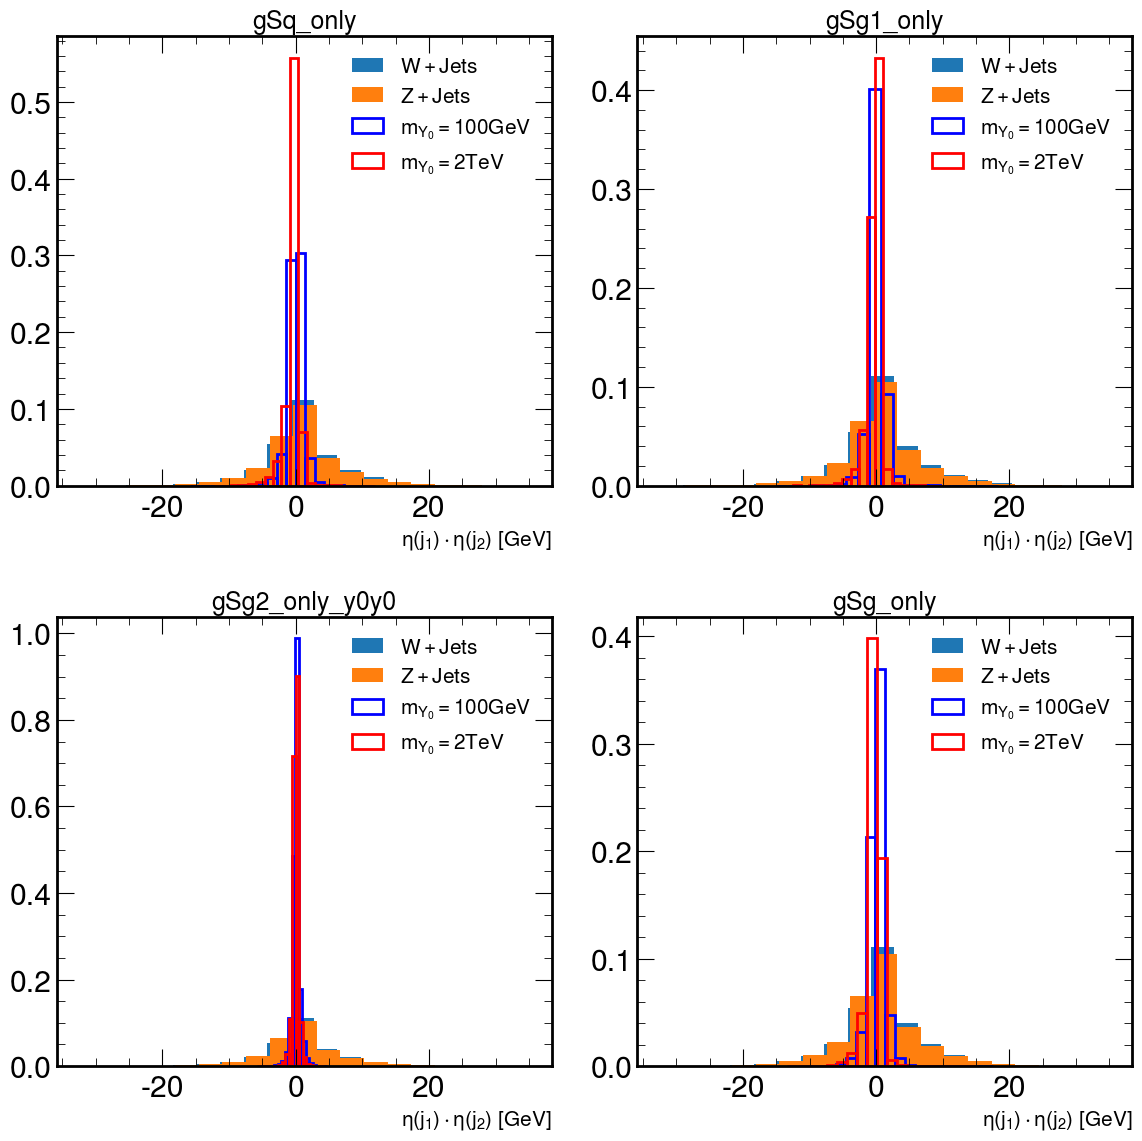

In [23]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'pseudorapidityProd'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$W+Jets$",r"$Z+Jets$", r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$ [GeV]",fontsize=15)


fig.tight_layout()
plt.show()


# Significance

Weights

$$W = \frac{N_{fisicos}}{N_{MG+Pythia}}$$

In [12]:
Weights = pd.read_csv("BGweigths.csv").to_dict()
# Luminosity to normalize
lum = 1 # fb-1

for i in cases:
    Weights[i] = []
    for j in range(2):
        Weights[i].append(CSs[i][j]*1000*lum/data[i][j].shape[0])

In [13]:
Weights['WpJets'] = Weights['WpJets'][0]
Weights['ZpJets'] = Weights['ZpJets'][0]
Weights.pop('Unnamed: 0')

{0: 0}

In [14]:
Weights

{'WpJets': 19.35116374450751,
 'ZpJets': 5.5599459000968485,
 'gSq_only': [0.002, 0.002],
 'gSg1_only': [0.8232, 0.1393],
 'gSg2_only_y0y0': [0.002, 0.002],
 'gSg_only': [0.824, 0.13944]}

In [15]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:326: RuntimeWarning: invalid value encountered in double_scalars
  Z[i][j][k] = S / np.sqrt(S + B)


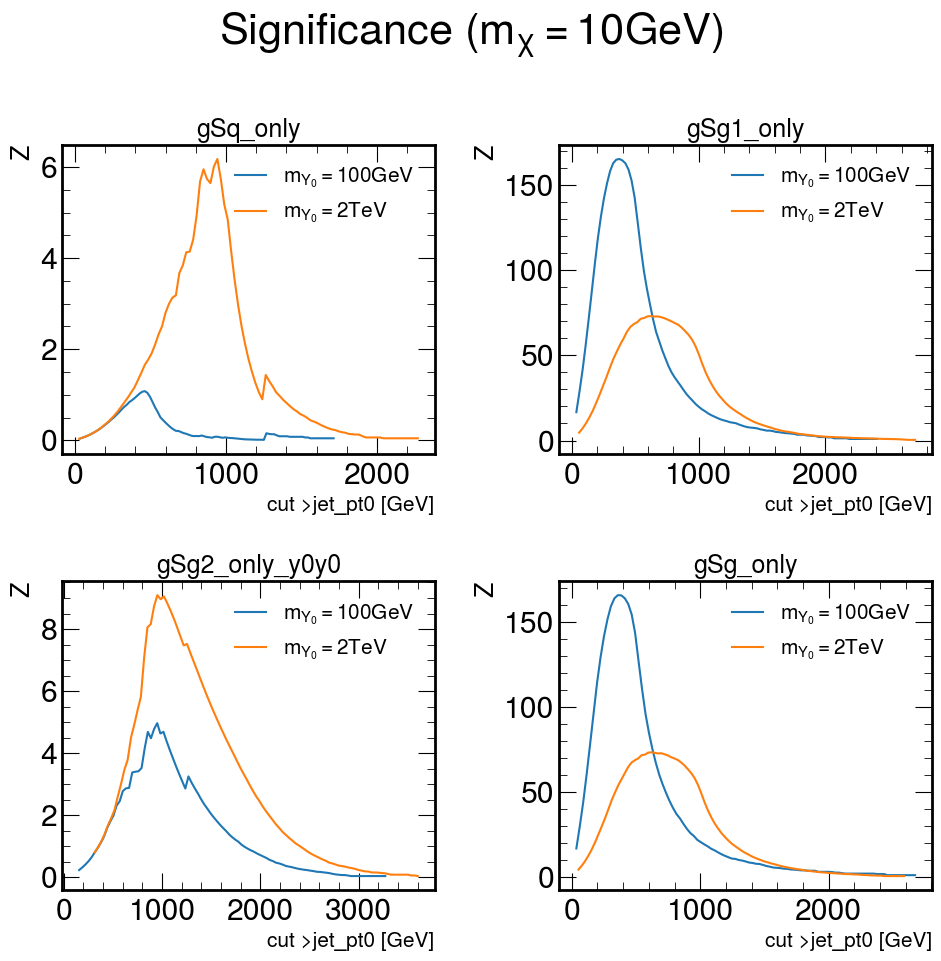

In [16]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

Acotamos el rango de busqueda

In [17]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt0', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1500), size=500)

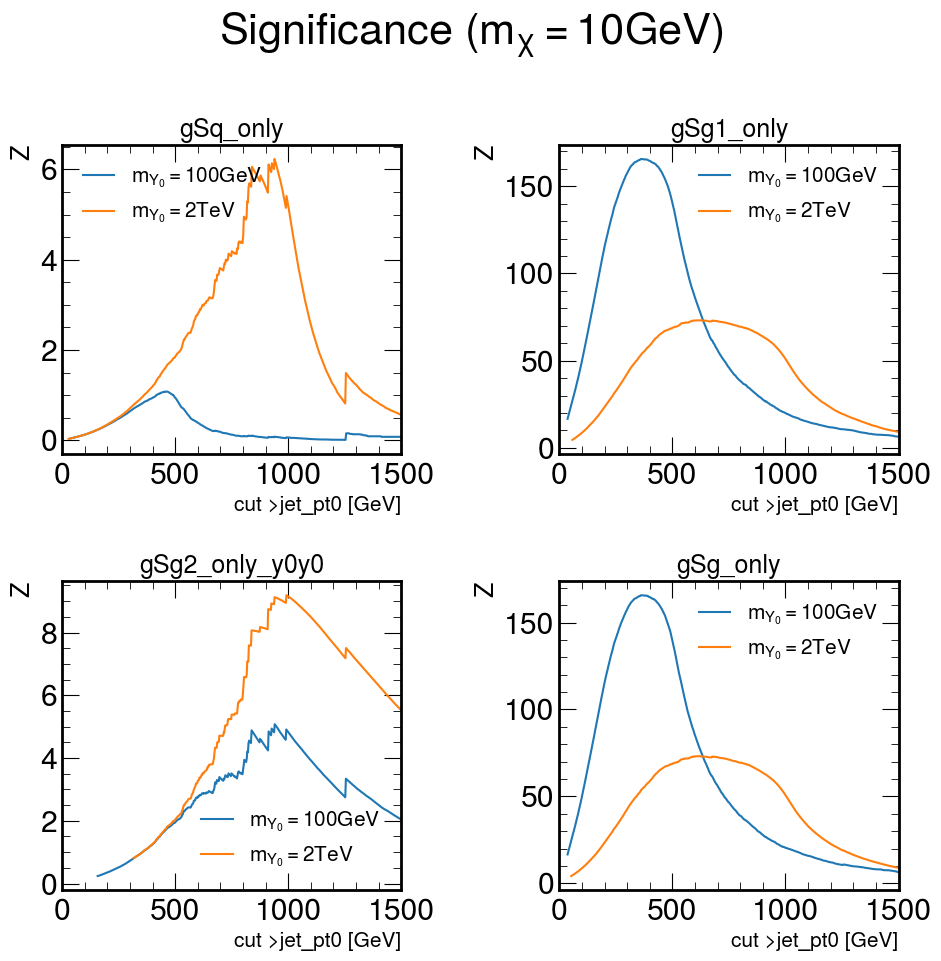

In [18]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1500)

fig.tight_layout()
plt.show()

In [19]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt0", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 1.080159935232787
		cut: jet_pt0 > 464.101GeV
	mass point: my0=2TeV
		max significance: 6.2294267252037905
		cut: jet_pt0 > 939.476GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 165.6605433550792
		cut: jet_pt0 > 361.721GeV
	mass point: my0=2TeV
		max significance: 73.17980097163112
		cut: jet_pt0 > 621.052GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 5.07798979442718
		cut: jet_pt0 > 940.208GeV
	mass point: my0=2TeV
		max significance: 9.189593061962707
		cut: jet_pt0 > 992.03GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 165.73287410691918
		cut: jet_pt0 > 361.629GeV
	mass point: my0=2TeV
		max significance: 73.16483304950161
		cut: jet_pt0 > 620.927GeV


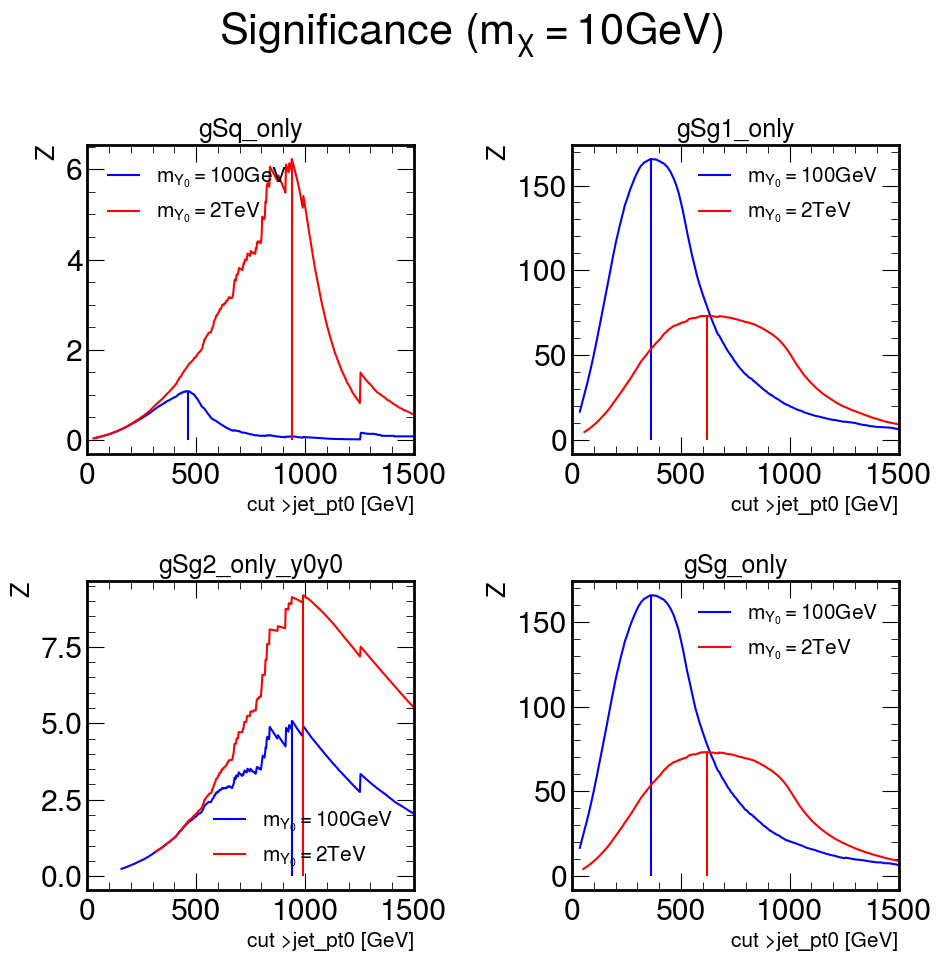

In [20]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt0 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1500)

fig.tight_layout()
plt.show()

In [21]:
cut_data = {}
dataWpJ_cut = {}
dataZpJ_cut = {}
for i in cases:
    cut_data[i] = []
    dataWpJ_cut[i] = []
    dataZpJ_cut[i] = []
    for j in range(2):
        #cut_data[i].append(data[i][j][data[i][j]['jet_pt0'] > cuts[i][j]].copy())
        #dataWpJ_cut[i].append(data_WpJ[data_WpJ['jet_pt0'] > cuts[i][j]].copy())
        #dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > cuts[i][j]].copy())
        cut_data[i].append(data[i][j][data[i][j]['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        dataWpJ_cut[i].append(data_WpJ[data_WpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV

In [22]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("\tCut")
print("Modelos: ",[[cut_data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("\nOrden: ","gSg_only", "gSg1_only", "gSg2_only_y0y0", "gSq_only")

Número de Eventos para cada caso:
	Original
Modelos:  [[50000, 50000], [50000, 50000], [50000, 50000], [50000, 50000]]
WpJets + ZpJets:  [1650663, 1596306]
	Cut
Modelos:  [[44350, 48842], [45453, 49050], [49951, 50000], [45421, 49136]]
WpJets:  [[708, 708], [708, 708], [708, 708], [708, 708]]
ZpJets:  [[933, 933], [933, 933], [933, 933], [933, 933]]

Orden:  gSg_only gSg1_only gSg2_only_y0y0 gSq_only


Cut in jet_pt1

In [81]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('jet_pt0 > 300')

data_WpJ = data_WpJ.query('jet_pt0 > 300')
data_ZpJ = data_ZpJ.query('jet_pt0 > 300')

In [82]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[44350, 48842], [45453, 49050], [49951, 50000], [45421, 49136]]
WpJets + ZpJets:  [708, 933]


In [83]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']])

/tmp/ipykernel_5920/3813981139.py:41: RuntimeWarning: invalid value encountered in double_scalars
  Z[i][j][k] = S/np.sqrt(S+B)


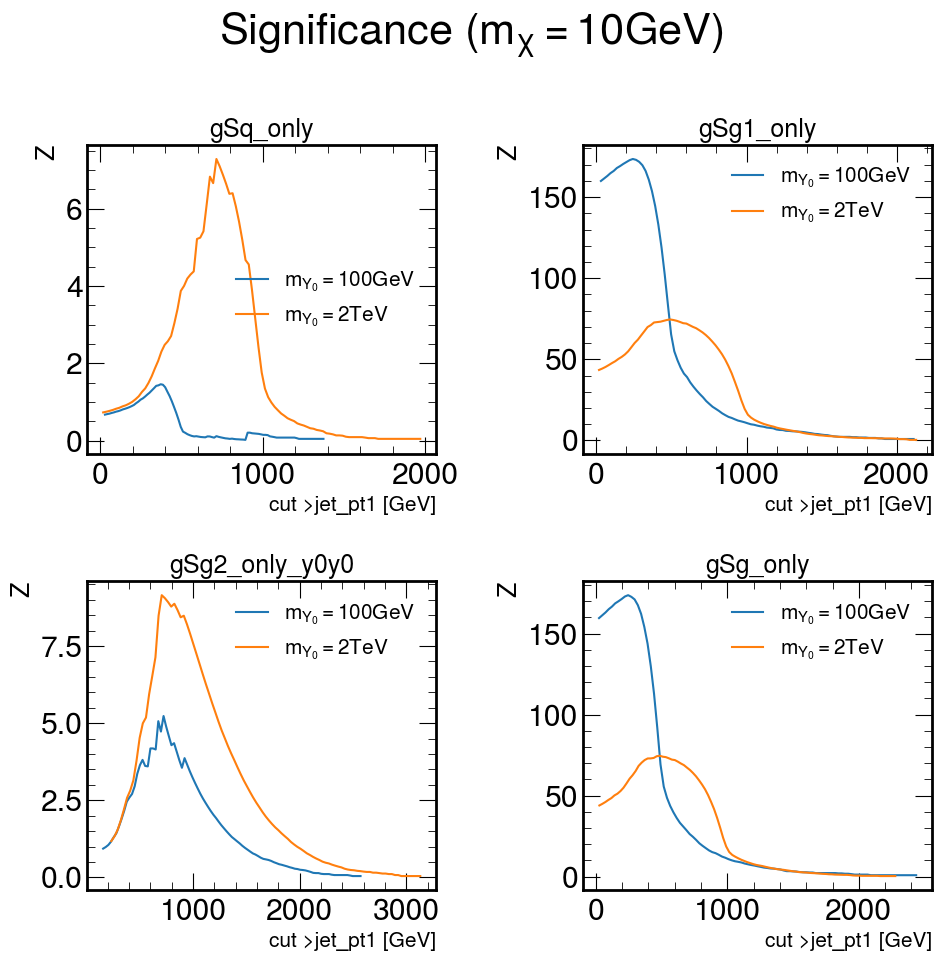

In [84]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

In [85]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='jet_pt1', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']],
                                 set_lims=True, lims=(0,1000), size=500)

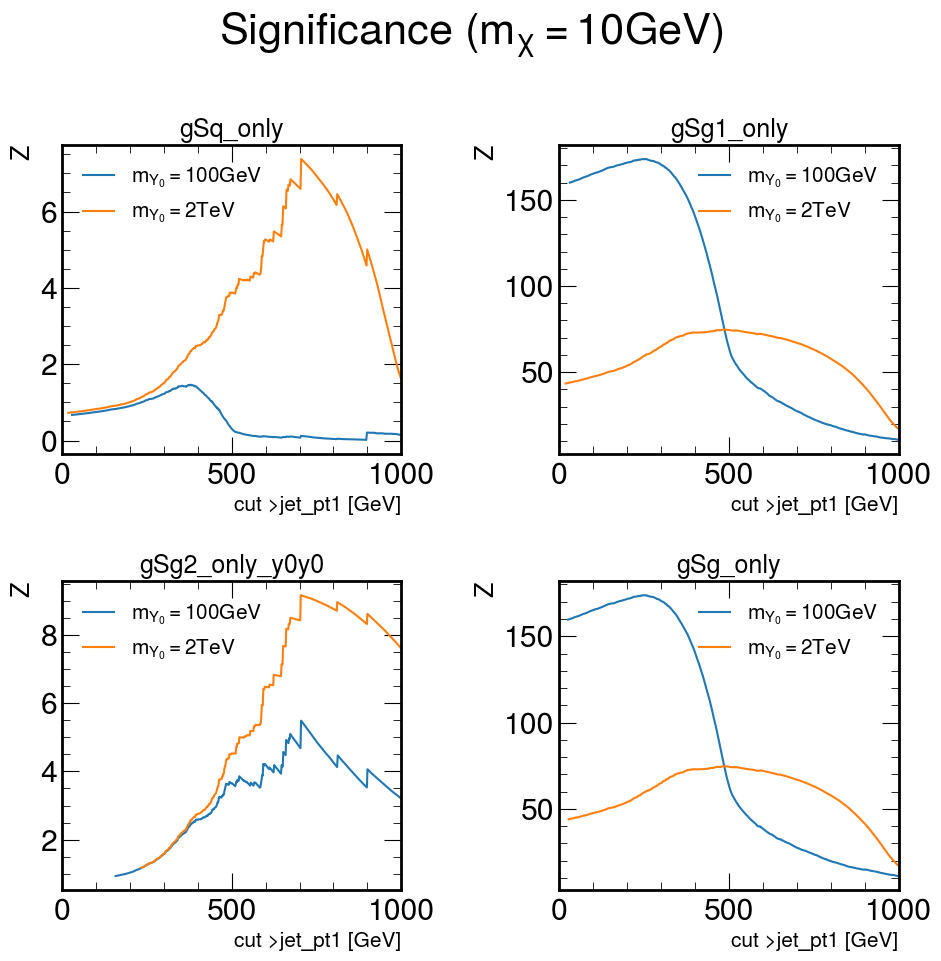

In [86]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)

fig.tight_layout()
plt.show()

In [87]:
cuts = get_cuts(cases, Z, pt_values, "jet_pt1", "GeV", ["my0=100GeV", "my0=2TeV"], printResults=True)

case : gSq_only
	mass point: my0=100GeV
		max significance: 1.4636212230688925
		cut: jet_pt1 > 379.429GeV
	mass point: my0=2TeV
		max significance: 7.378220965208673
		cut: jet_pt1 > 704.887GeV
case : gSg1_only
	mass point: my0=100GeV
		max significance: 173.66315575976336
		cut: jet_pt1 > 255.9GeV
	mass point: my0=2TeV
		max significance: 74.79462720109441
		cut: jet_pt1 > 484.379GeV
case : gSg2_only_y0y0
	mass point: my0=100GeV
		max significance: 5.483930241013508
		cut: jet_pt1 > 704.534GeV
	mass point: my0=2TeV
		max significance: 9.15970380504003
		cut: jet_pt1 > 703.69GeV
case : gSg_only
	mass point: my0=100GeV
		max significance: 173.80516354214942
		cut: jet_pt1 > 247.596GeV
	mass point: my0=2TeV
		max significance: 74.73815218296379
		cut: jet_pt1 > 483.51GeV


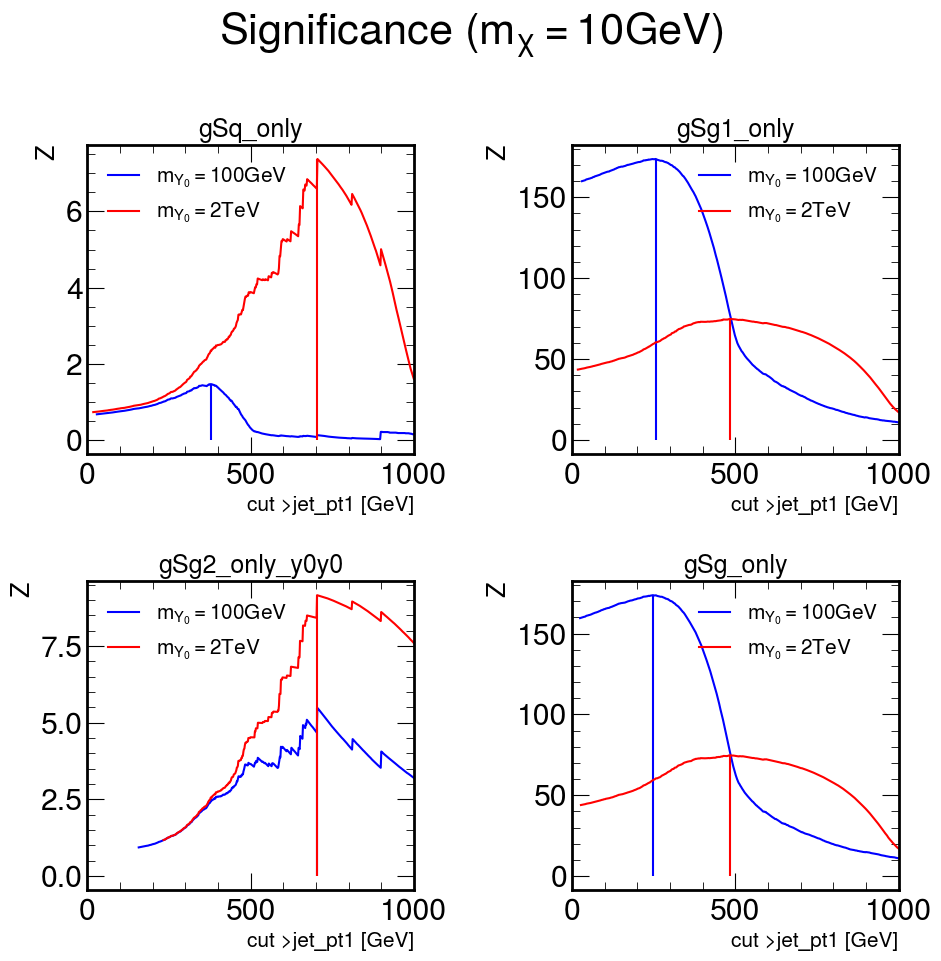

In [88]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

colors = ["b","r"]
labels = [r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"]

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i],color=colors[i], label=labels[i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i],color=colors[i], label=labels[i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i],color=colors[i], label=labels[i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i],color=colors[i], label=labels[i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)
    ax[0,0].vlines(cuts[cases[0]][i], ymin=0, ymax=max(Z[cases[0]][i]),color=colors[i])
    ax[0,1].vlines(cuts[cases[1]][i], ymin=0, ymax=max(Z[cases[1]][i]),color=colors[i])
    ax[1,0].vlines(cuts[cases[2]][i], ymin=0, ymax=max(Z[cases[2]][i]),color=colors[i])
    ax[1,1].vlines(cuts[cases[3]][i], ymin=0, ymax=max(Z[cases[3]][i]),color=colors[i])

for i in range(2):
    for j in range(2):
        ax[i,j].legend(fontsize=15)
        ax[i,j].set_xlabel("cut >jet_pt1 [GeV]",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        ax[i,j].set_xlim(0,1000)

fig.tight_layout()
plt.show()

In [89]:
cut_data = {}
dataWpJ_cut = {}
dataZpJ_cut = {}
for i in cases:
    cut_data[i] = []
    dataWpJ_cut[i] = []
    dataZpJ_cut[i] = []
    for j in range(2):
        cut_data[i].append(data[i][j][data[i][j]['jet_pt0'] > cuts[i][j]].copy())
        dataWpJ_cut[i].append(data_WpJ[data_WpJ['jet_pt0'] > cuts[i][j]].copy())
        dataZpJ_cut[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > cuts[i][j]].copy())
        #cut_data2[i].append(data[i][j][data[i][j]['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataWpJ_cut2[i].append(data_WpJ[data_WpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV
        #dataZpJ_cut2[i].append(data_ZpJ[data_ZpJ['jet_pt0'] > 300].copy()) # jet_pt0 > 300GeV

In [90]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])
print("\tCut")
print("Modelos: ",[[cut_data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets: ",[[dataWpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("ZpJets: ",[[dataZpJ_cut[i][j].shape[0] for j in range(2)] for i in cases])
print("\nOrden: ","gSg_only", "gSg1_only", "gSg2_only_y0y0", "gSq_only")

Número de Eventos para cada caso:
	Original
Modelos:  [[44350, 48842], [45453, 49050], [49951, 50000], [45421, 49136]]
WpJets + ZpJets:  [708, 933]
	Cut
Modelos:  [[39052, 38862], [45453, 46422], [33674, 49491], [45421, 46441]]
WpJets:  [[286, 14], [708, 100], [14, 14], [708, 101]]
ZpJets:  [[387, 13], [933, 117], [13, 13], [933, 120]]

Orden:  gSg_only gSg1_only gSg2_only_y0y0 gSq_only


In [91]:
for i in cases:
    for j in range(2):
        data[i][j] = data[i][j].query('jet_pt1 > 300')

data_WpJ = data_WpJ.query('jet_pt1 > 300')
data_ZpJ = data_ZpJ.query('jet_pt1 > 300')

In [92]:
print("Número de Eventos para cada caso:")
print("\tOriginal")
print("Modelos: ",[[data[i][j].shape[0] for j in range(2)] for i in cases])
print("WpJets + ZpJets: ",[data_WpJ.shape[0], data_ZpJ.shape[0]])

Número de Eventos para cada caso:
	Original
Modelos:  [[38366, 47345], [39434, 47758], [49564, 49993], [39438, 47779]]
WpJets + ZpJets:  [152, 165]


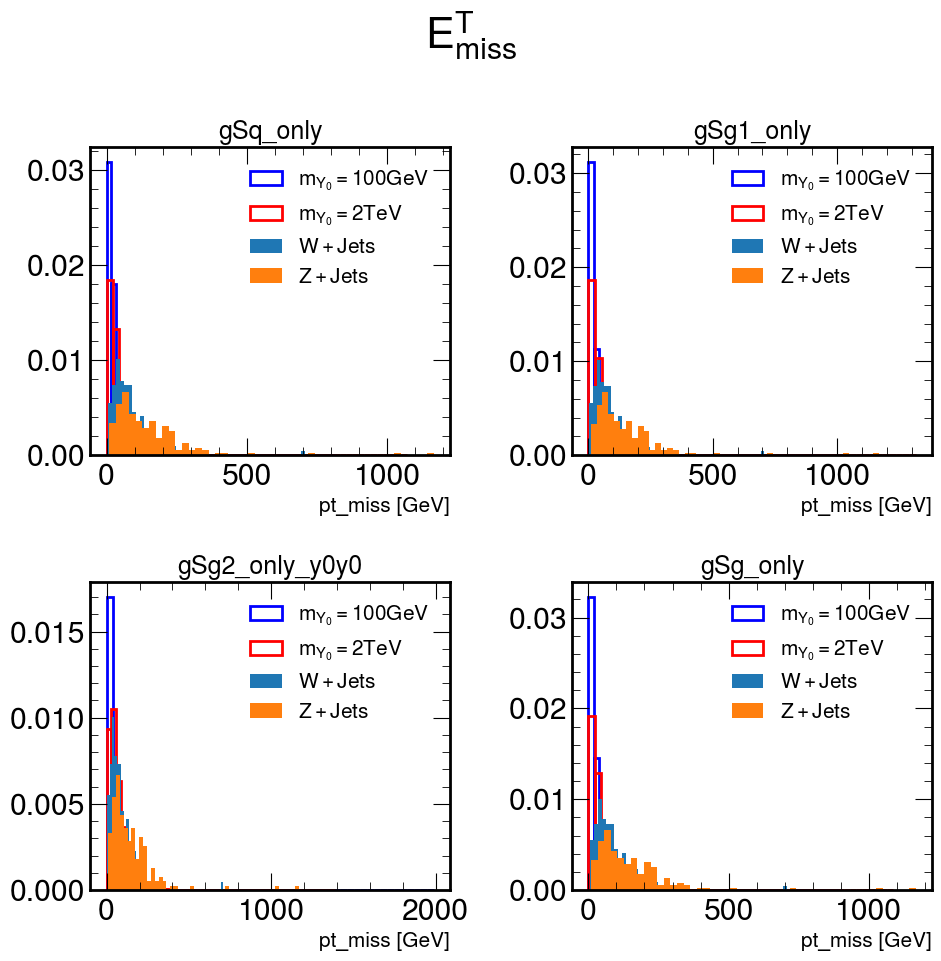

In [98]:
fig, ax = plt.subplots(2,2)
fig.suptitle(r"$E^{T}_{miss}$")

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j]['missinget_met']),max(data[i][j]['missinget_met'])))

rangos['WpJets'] = np.linspace(min(data_WpJ['missinget_met']), max(data_WpJ['missinget_met']))
rangos['ZpJets'] = np.linspace(min(data_ZpJ['missinget_met']), max(data_ZpJ['missinget_met']))

colors = ['blue', 'red']

for i in range(2):
    ax[0,0].hist(data[cases[0]][i]['missinget_met'], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i]['missinget_met'], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i]['missinget_met'], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i]['missinget_met'], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ['missinget_met'], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ['missinget_met'], bins=rangos['ZpJets'], density=True)
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV",r"$W+Jets$",r"$Z+Jets$"],fontsize=15)
        ax[i,j].set_xlabel("pt_miss [GeV]",fontsize=15)

fig.tight_layout()
plt.show()


#### VBF variables

$\eta(j_{1}) \cdot \eta(j_{2})$

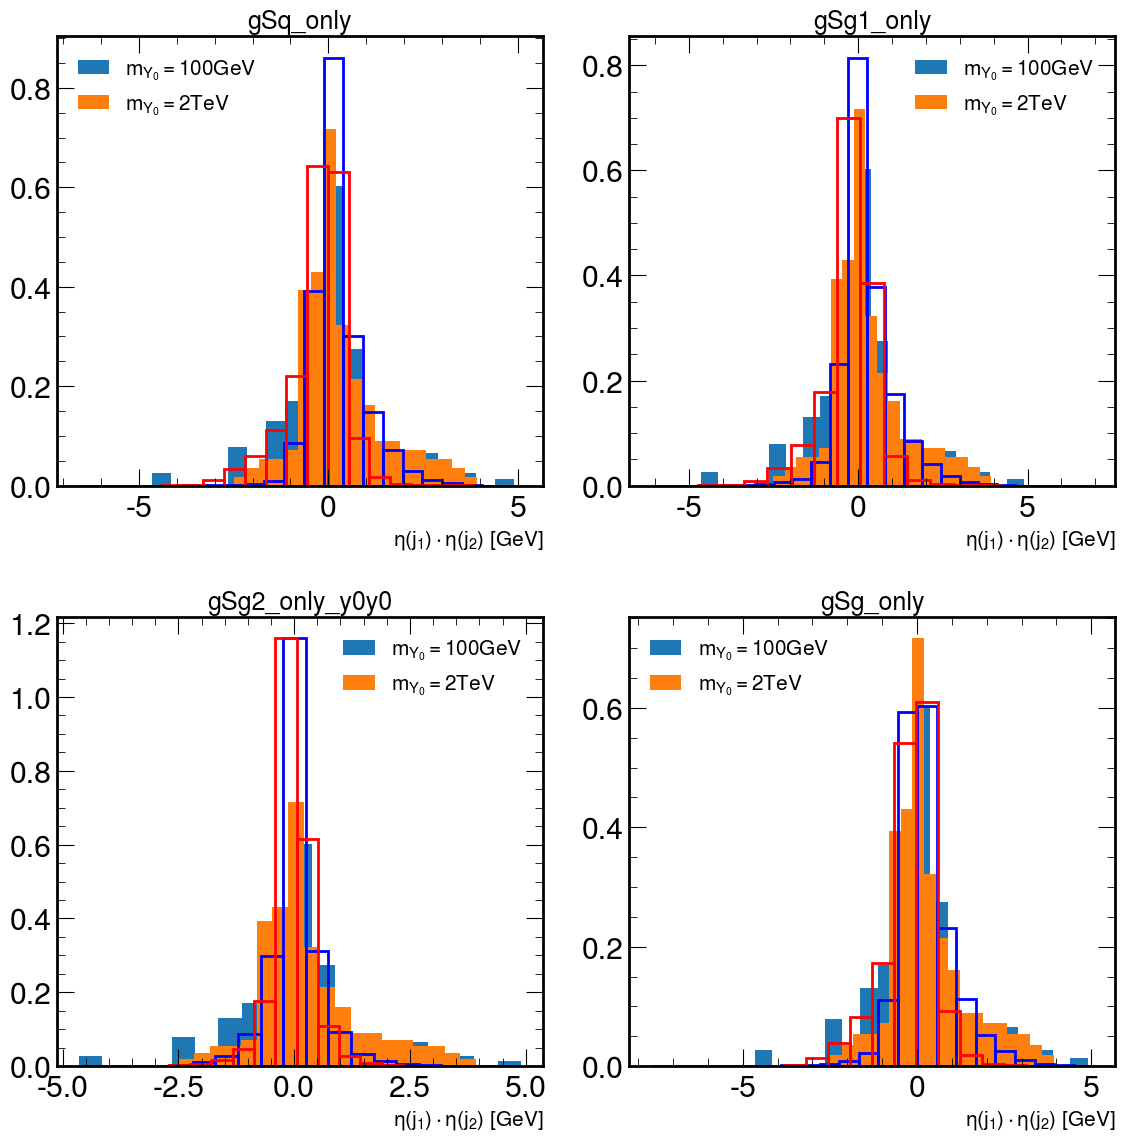

In [122]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
#fig.suptitle(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$")

variable = 'pseudorapidityProd'
nBins = 20

rangos = {}
for i in cases:
    rangos[i] = []
    for j in range(2):
        rangos[i].append(np.linspace(min(data[i][j][variable]),max(data[i][j][variable]), nBins))

rangos['WpJets'] = np.linspace(min(data_WpJ[variable]), max(data_WpJ[variable]), nBins)
rangos['ZpJets'] = np.linspace(min(data_ZpJ[variable]), max(data_ZpJ[variable]), nBins)

colors = ['blue', 'red']

for i in range(2):
    for j in range(2):
        ax[i,j].hist(data_WpJ[variable], bins=rangos['WpJets'], density=True)
        ax[i,j].hist(data_ZpJ[variable], bins=rangos['ZpJets'], density=True)
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV",r"$W+Jets$",r"$Z+Jets$"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$ [GeV]",fontsize=15)

for i in range(2):
    ax[0,0].hist(data[cases[0]][i][variable], bins=rangos[cases[0]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,1].hist(data[cases[1]][i][variable], bins=rangos[cases[1]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,0].hist(data[cases[2]][i][variable], bins=rangos[cases[2]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[1,1].hist(data[cases[3]][i][variable], bins=rangos[cases[3]][i], density=True, color=colors[i], edgecolor=colors[i], fc='None', lw=2)
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)


fig.tight_layout()
plt.show()


In [109]:
Z, pt_values = find_significance(cases, data, [data_WpJ, data_ZpJ],
                                 cut_var='pseudorapidityProd', use_weights=True, SG_weights=Weights,
                                 BG_weights=[Weights['WpJets'], Weights['ZpJets']], cond='<')

/tmp/ipykernel_5920/2352393901.py:51: RuntimeWarning: invalid value encountered in double_scalars
  Z[i][j][k] = S/np.sqrt(S+B)


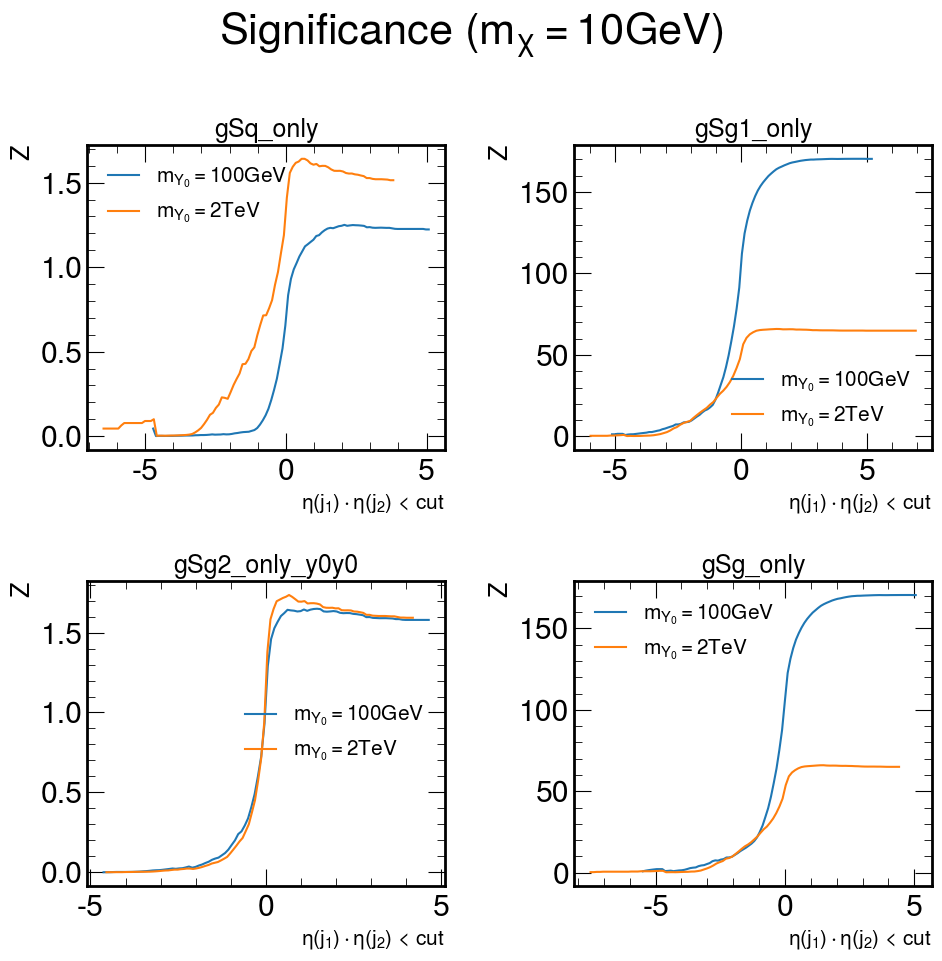

In [113]:
fig, ax = plt.subplots(2,2)

fig.suptitle(r"Significance ($m_{\chi} = 10$GeV)")

for i in range(2):
    ax[0,0].plot(pt_values[cases[0]][i], Z[cases[0]][i])
    ax[0,1].plot(pt_values[cases[1]][i], Z[cases[1]][i])
    ax[1,0].plot(pt_values[cases[2]][i], Z[cases[2]][i])
    ax[1,1].plot(pt_values[cases[3]][i], Z[cases[3]][i])
    ax[0,0].set_title(cases[0], fontsize=18)
    ax[0,1].set_title(cases[1], fontsize=18)
    ax[1,0].set_title(cases[2], fontsize=18)
    ax[1,1].set_title(cases[3], fontsize=18)

for i in range(2):
    for j in range(2):
        ax[i,j].legend([r"$m_{Y_{0}}=100$GeV",r"$m_{Y_{0}}=2$TeV"],fontsize=15)
        ax[i,j].set_xlabel(r"$\eta{(j_{1})}\cdot\eta{(j_{2})}$ < cut",fontsize=15)
        ax[i,j].set_ylabel("Z",fontsize=18)
        #ax[i,j].set_xlim(0,2000)

fig.tight_layout()
plt.show()

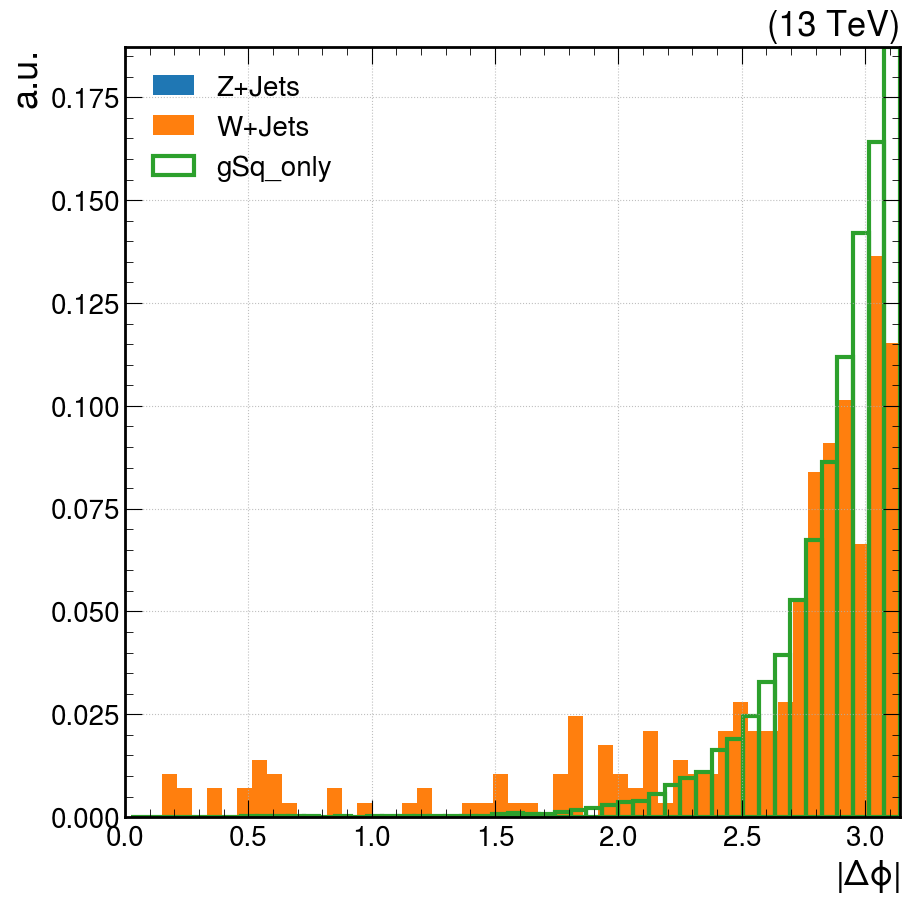

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(
/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(


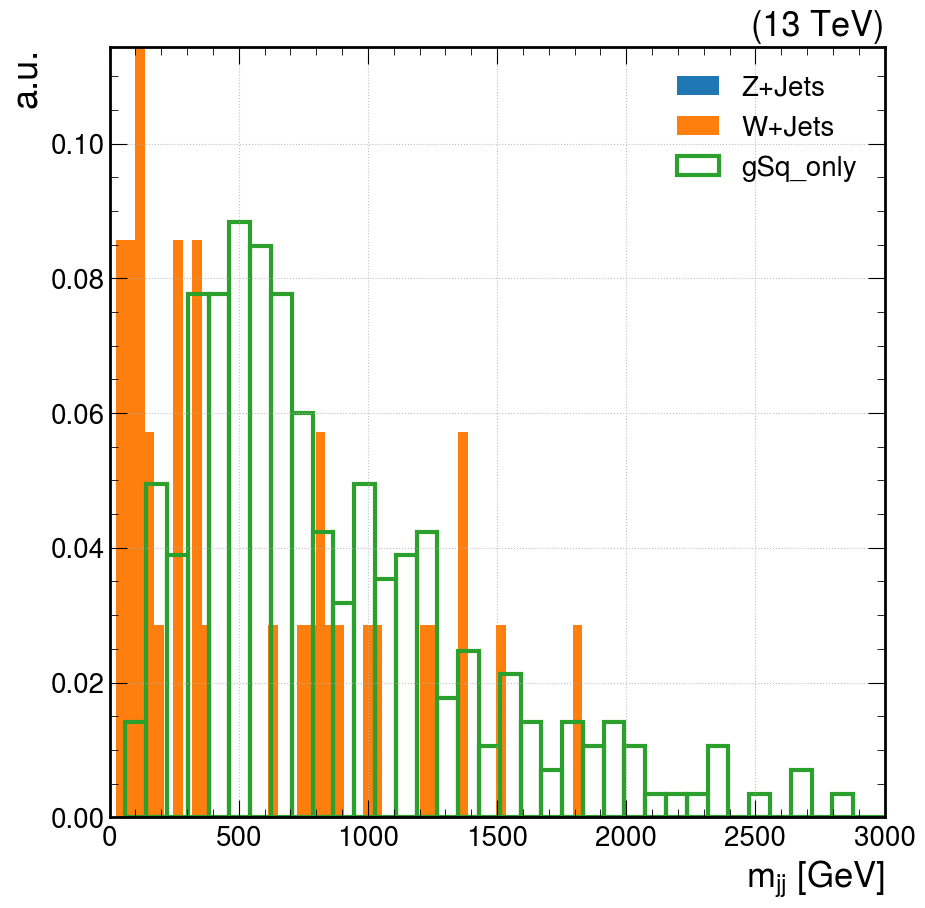

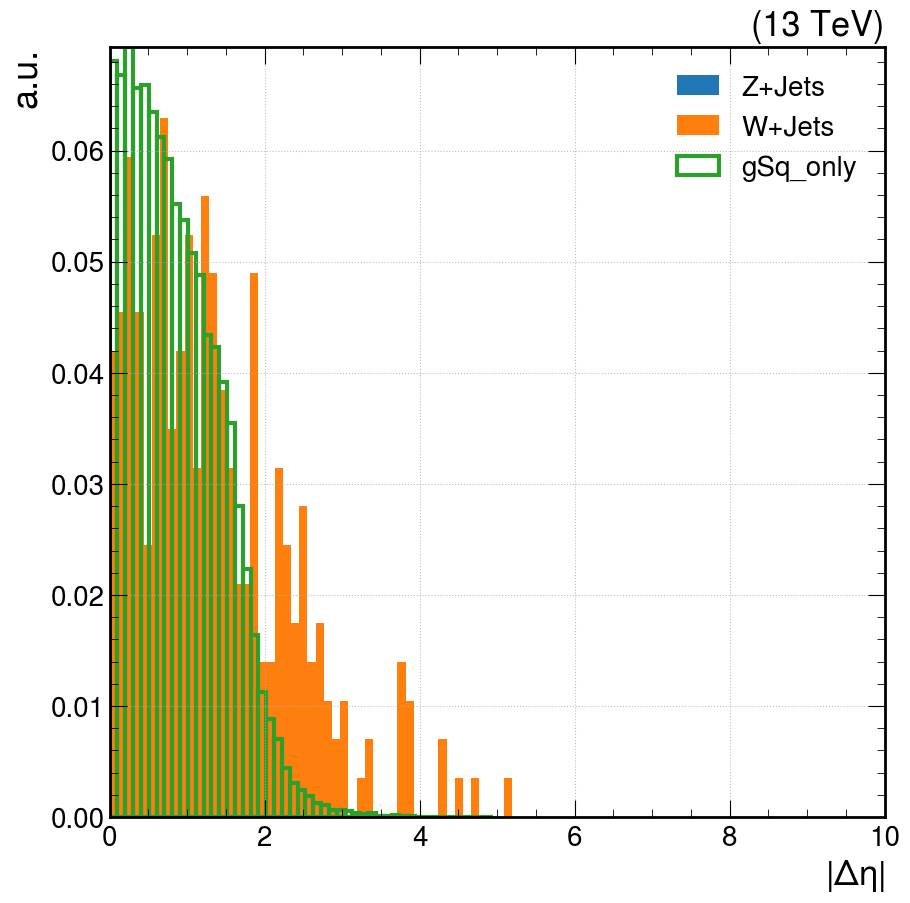

In [42]:
datas = [dataWpJ_cut['gSq_only'][0], dataWpJ_cut['gSq_only'][0], cut_data['gSq_only'][0]]
names = ['Z+Jets','W+Jets','gSq_only']
plotObservable(datas, names, 'Azim_diff', save=False, plot=True)
plotObservable(datas, names, 'Inv_mass', save=False, plot=True)
plotObservable(datas, names, 'Pseudorapidity', save=False, plot=True)

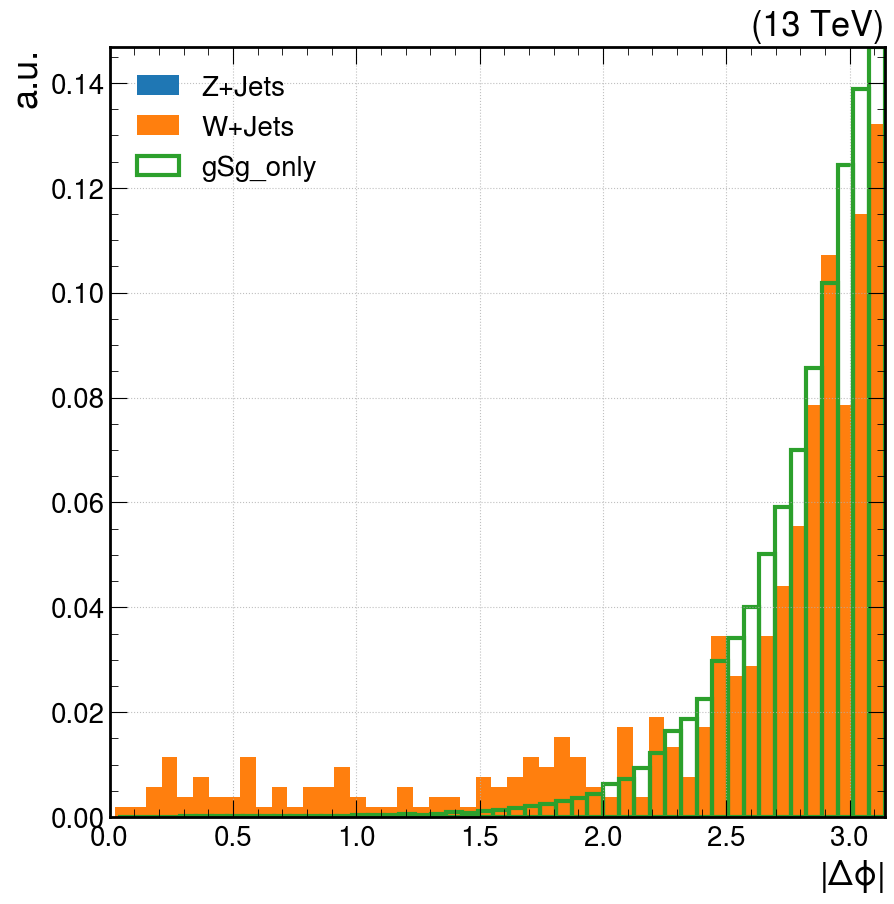

/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(
/home/juan/Documents/GitHub/VBFDM_EAFIT/funcs.py:121: RuntimeWarning: invalid value encountered in sqrt
  m = np.sqrt(


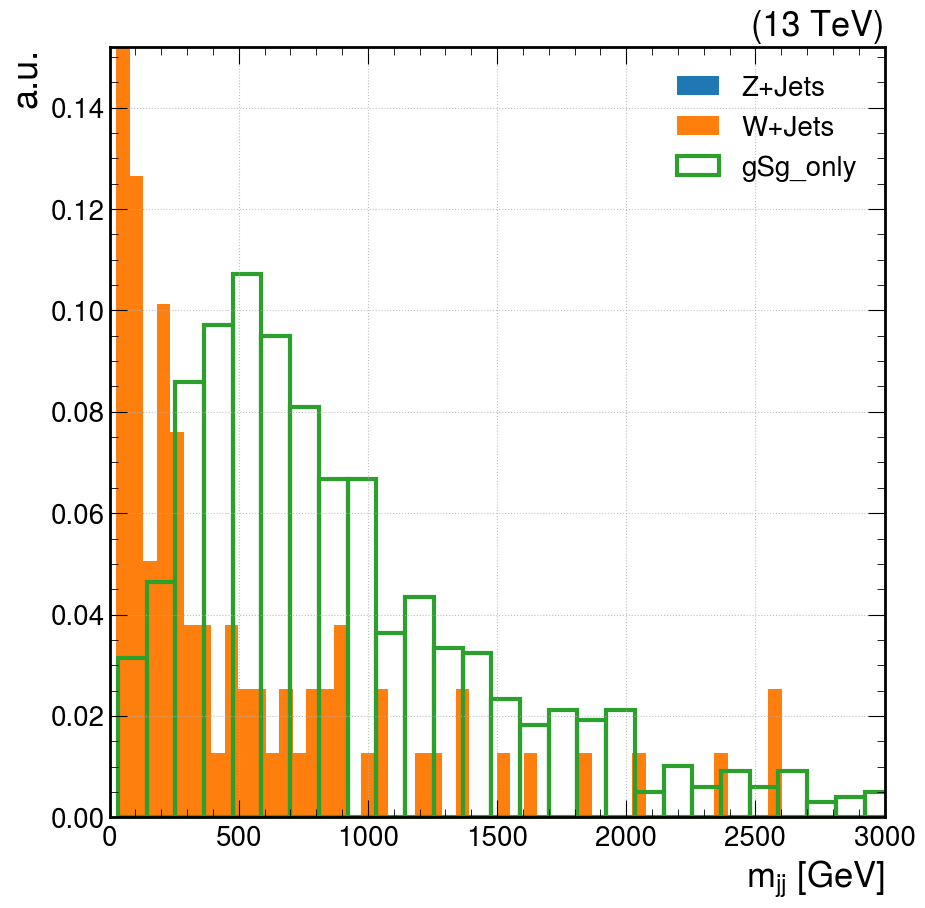

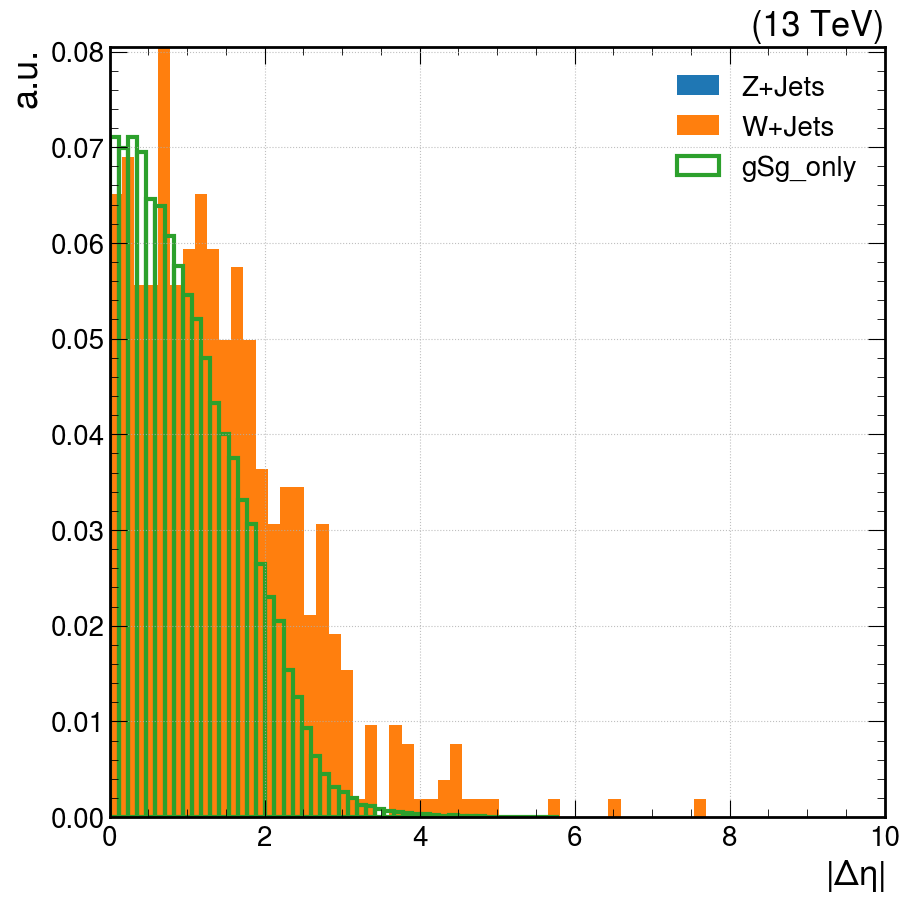

In [48]:
datas = [dataWpJ_cut['gSg_only'][0], dataWpJ_cut['gSg_only'][0], cut_data['gSg_only'][0]]
names = ['Z+Jets','W+Jets','gSg_only']
plotObservable(datas, names, 'Azim_diff', save=False, plot=True)
plotObservable(datas, names, 'Inv_mass', save=False, plot=True)
plotObservable(datas, names, 'Pseudorapidity', save=False, plot=True)